In [7]:
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot, uncertainty_plot, sorted_plot
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from mapie.regression import MapieRegressor

import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings('ignore')

# read in necessary material
folder = '/mnt/primus/xuemeng_tmp_harbour/soc'
test = pd.read_csv(f'{folder}/data/004.0_validate.pnts_oc.csv',low_memory=False)
# train = pd.read_csv(f'{folder}/data/005.0_train.pnts_oc.csv',low_memory=False)
train = pd.read_csv(f'{folder}/data/005.2_train.pnts_oc.org.csv',low_memory=False)

train = pd.concat([train] * 10, ignore_index=True)


# covariates
# /SOC-EU/features/002_selected.covar_rank.freq.txt
with open(f'{folder}/SOC-EU/features/002.4_selected.covar,balanced_mnr.org.intersection.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]

# dataset
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

# spatial cross validation
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)

# score
from tool_kit import calc_ccc
from sklearn.metrics import make_scorer
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)

### spatial cross validation

In [2]:
model_list = find_files(f'{folder}/SOC-EU/model/','*model*.joblib')
model_list = [str(i) for i in model_list]
model_list

['/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/004.1_model_rf.log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/005.1_model_rf.normal.rmse.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/001.1_model_rf.log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/002.1_model_ann.log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/003.1_model_cubist.log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/004.1_model_rf.log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/005.1_model_cubist.log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/010.1_model_cubist.normal.rmse.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_base.model/013.1_model_cubist.normal.rmse.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test

In [ ]:
results = []

for model_path in model_list[1::]:
    model_name = model_path.split('_')[-1][0:-7]
    model = joblib.load(model_path)
    
    if 'log1p' in model_path:
        tgt = 'oc_log1p'
    else:
        tgt = 'oc'
        
        
    group_kfold = GroupKFold(n_splits=5)

    ttprint(f'spatial CV for {model_name}, from {model_path}')
    
    y_pred_cv = np.zeros(len(train))
    
    to = 1
    for train_index, test_index in group_kfold.split(train[covs], train[tgt], groups=train[spatial_cv_column]):
        print(f'cv: {to}')
        X_train, X_test = train[covs].iloc[train_index], train[covs].iloc[test_index]
        y_train, y_test = train[tgt].iloc[train_index], train[tgt].iloc[test_index]
        if 'weight' not in model_path:
            model.fit(X_train, y_train)
        else:
            weights_train = train['oc_qa'].iloc[train_index].values**2
            if 'cubist' in model_path:
                fit_params = {'cubist__sample_weight': weights_train}
                model.fit(X_train, y_train, **fit_params)
            if 'rf' in model_path:
                model.fit(X_train, y_train, sample_weight = weights_train)
                
        y_pred_cv[test_index] = model.predict(X_test)
        to = to+1

    ttprint(f'finish spatial cv')
    
    # Calculate metrics, and visualize the results
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name + '-CV')  # visualization
    # error_spatial_plot(train[tgt], y_pred_cv, train['lat'], train['lon'], model_name)
    # sorted_plot(train[tgt], y_pred_cv, model_name)

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2_CV': r2_cv,
        'RMSE_CV': rmse_cv,
        'CCC_CV': ccc_cv
    })


The model does not have an n_jobs parameter
[09:17:49] spatial CV for cubist.log1p.ccc.weighted, from /mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/0010.1_model_cubist.log1p.ccc.weighted.joblib
cv: 1


### individual validation

In [2]:
model_list = find_files(f'{folder}/SOC-EU/model/','*model*.joblib')
model_list = [str(i) for i in model_list]
model_list = ['/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.org.balanced_rf.log1p.ccc.weighted.joblib']
              # '/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/model/test_model.mnr.balanced_rf.log1p.ccc.weighted.joblib']

[12:43:26] start fittining model


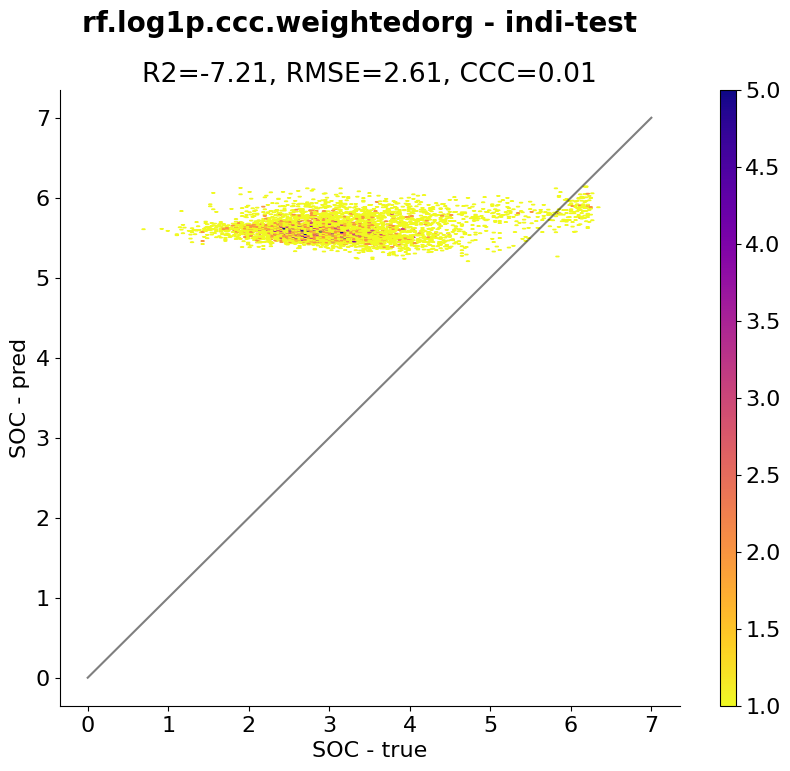

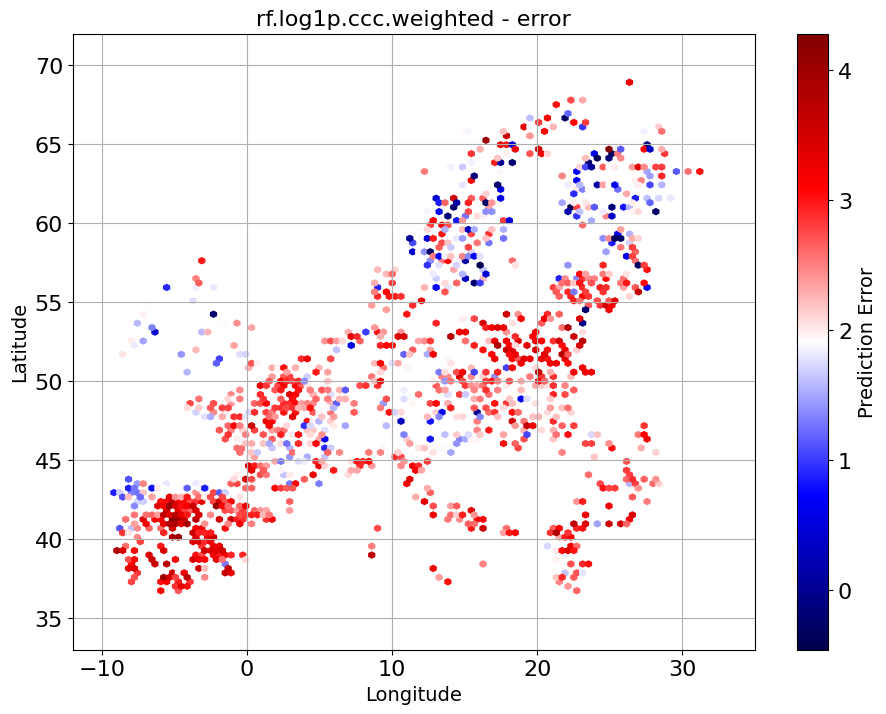

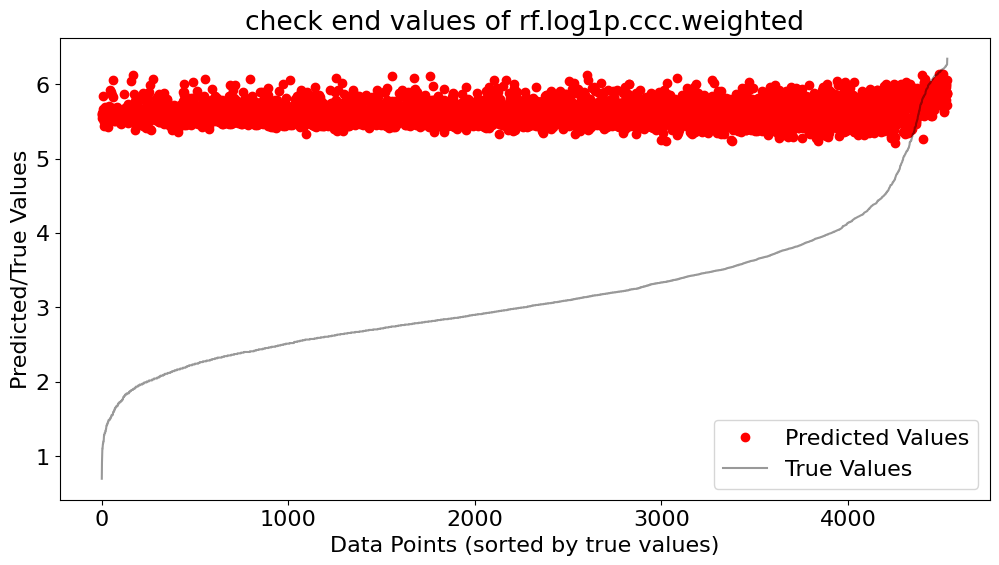

In [3]:
# get all the trained models
from tool_kit import error_spatial_plot, sorted_plot
import time

results = []
warnings.filterwarnings("ignore")
for model_path in model_list:
    model_name = model_path.split('_')[-1][0:-7]
    model = joblib.load(model_path)
    
    if 'log1p' in model_path:
        tgt = 'oc_log1p'
    else:
        tgt = 'oc'
        
    if 'weight' in model_path:
        sample_weights = train['oc_qa'].values**2
    else:
        sample_weights=None
        
    ttprint('start fittining model')
    start_time = time.time()
    if 'rf' in model_path:
        model.fit(train[covs], train[tgt], sample_weight=sample_weights)
    else:
        if sample_weights is not None:
            fit_params = {'cubist__sample_weight': sample_weights}
            model.fit(train[covs], train[tgt], **fit_params)
        else:
            model.fit(train[covs], train[tgt])
    end_time = time.time()
    training_time = (end_time - start_time)
    joblib.dump(model, model_path)

    start_time = time.time()
    y_pred_val = model.predict(test[covs])
    end_time = time.time()
    testing_time = (end_time - start_time) 
    
    if 'log1p' in model_path:
        y_true = test[tgt]
    else:
        y_true = np.log1p(test[tgt])
        y_pred_val = np.log1p(y_pred_val)
        
    r2_val, rmse_val, ccc_val = accuracy_plot(y_true, y_pred_val, model_name+ 'org - indi-test', vmax=5) # visuliazation
    error_spatial_plot(y_true, y_pred_val, test['lat'], test['lon'], model_name)
    sorted_plot(y_true,y_pred_val,model_name)
    
    # Filter data for y > 5.02
    y_true_gt = y_true[y_true > 5.02]
    y_pred_gt = y_pred_val[y_true > 5.02]
    
    # Filter data for y <= 5.02
    y_true_le = y_true[y_true <= 5.02]
    y_pred_le = y_pred_val[y_true <= 5.02]
    
    # Calculate metrics for y > 5.02
    r2_gt = r2_score(y_true_gt, y_pred_gt)
    rmse_gt = np.sqrt(mean_squared_error(y_true_gt, y_pred_gt))
    ccc_gt = calc_ccc(y_true_gt, y_pred_gt)
    
    # Calculate metrics for y <= 5.02
    r2_le = r2_score(y_true_le, y_pred_le)
    rmse_le = np.sqrt(mean_squared_error(y_true_le, y_pred_le))
    ccc_le = calc_ccc(y_true_le, y_pred_le)

    results.append({
        'title': model_name + ' - org',
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'R2_val_organic': r2_gt,
        'RMSE_val_organic': rmse_gt,
        'CCC_val_organic': ccc_gt,
        'R2_val_mineral': r2_le,
        'RMSE_val_mineral': rmse_le,
        'CCC_val_mineral': ccc_le,
        'train_time (s)': training_time,
        'predict_time (s)': testing_time
    })
    

In [4]:
a = y_true[y_true>5]
b = y_pred_val[y_true>5]

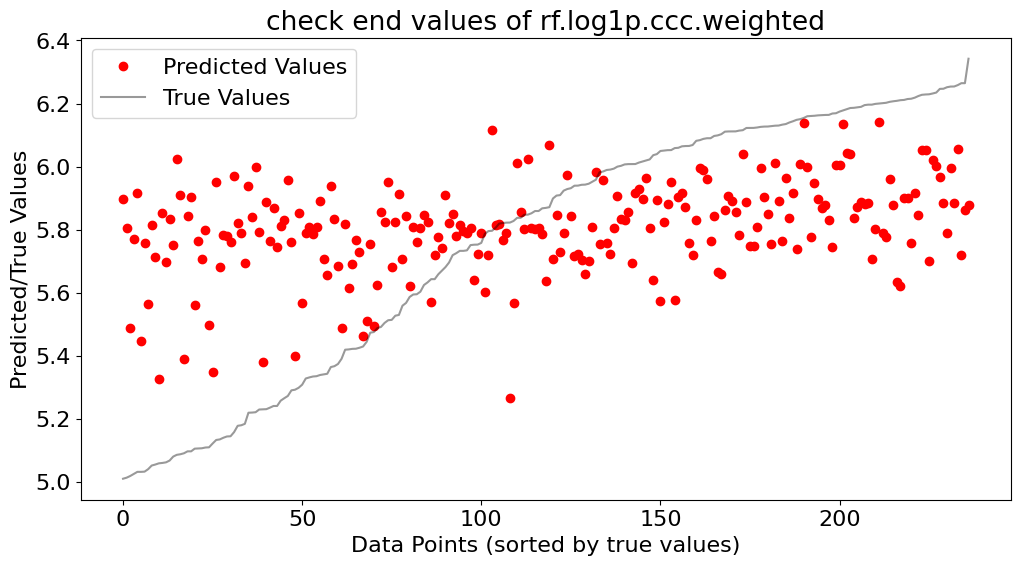

In [5]:
sorted_plot(a,b,model_name)

In [24]:
import numpy as np
np.expm1(6)

402.4287934927351

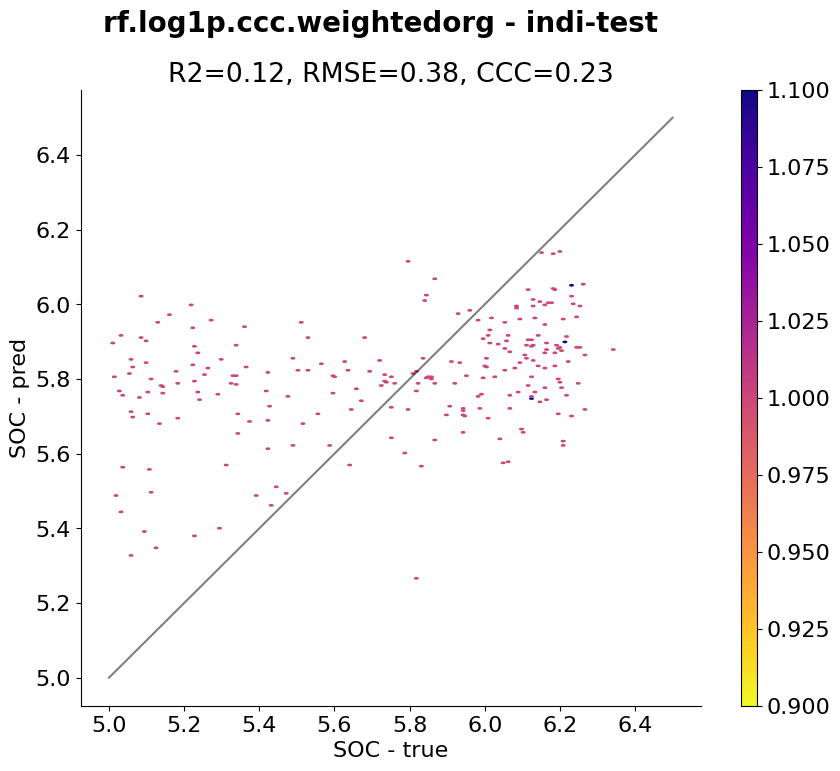

(0.12099035354560372, 0.3812960448793552, 0.2340121225630237)

In [6]:
accuracy_plot(a, b, model_name+ 'org - indi-test', show_range=[5,6.5], vmax=1) # visuliazation

In [6]:
results_val2 = pd.DataFrame(results)
results_val2
results_val = pd.read_csv(f'{folder}/SOC-EU/model/test_base.model/test_metrics_val.base.model.csv')
results_val = pd.concat([results_val, results_val2])
results_val.to_csv(f'{folder}/SOC-EU/model/test_base.model/test_metrics_val.base.model.csv', index=False)
results_val

,title,R2_val,RMSE_val,CCC_val,R2_val_organic,RMSE_val_organic,CCC_val_organic,R2_val_mineral,RMSE_val_mineral,CCC_val_mineral,train_time (s),predict_time (s)
0,rf.log1p.ccc,0.538898,0.619510,0.696779,-13.921687,1.546639,0.039872,0.425095,0.523907,0.679068,16.105375,0.125417
1,ann.log1p.ccc,0.502147,0.643725,0.681493,-12.954652,1.495683,0.041458,0.339863,0.561401,0.641858,20.571304,0.014152
2,cubist.log1p.ccc,0.538300,0.619912,0.714220,-13.064184,1.501542,0.043415,0.408322,0.531495,0.692432,448.743266,51.681682
3,rf.log1p.ccc.weighted,0.546138,0.614628,0.702684,-13.772244,1.538875,0.039981,0.435671,0.519066,0.686494,58.048035,0.236035
4,cubist.log1p.ccc.weighted,0.477105,0.659717,0.693053,-14.208507,1.561433,0.042505,0.316745,0.571147,0.668728,243.780972,35.241060
5,cubist.normal.rmse.weighted,0.392983,0.710805,0.687144,-5.784970,1.042927,0.110822,0.008153,0.688143,0.593476,458.438337,47.635853
6,cubist.normal.rmse,0.400295,0.706511,0.688721,-5.876478,1.049937,0.119097,0.023268,0.682879,0.596916,493.023318,64.438727
7,rf.normal.rmse.weighted,0.542884,0.616827,0.695902,-13.904551,1.545751,0.039333,0.432108,0.520702,0.678268,10.661618,0.382048
0,rf.normal.rmse.weighted - org,-8.112696,2.754061,0.001743,0.095944,0.380696,0.214694,-15.734946,2.826626,-0.002968,3.334272,0.564985
1,rf.log1p.ccc.weighted - org,-7.344374,2.635403,0.007059,0.149312,0.369288,0.238624,-14.323548,2.704805,-0.000161,3.579221,0.550564


In [ ]:
# df1 = pd.read_csv(f'{folder}/SOC-EU/model/test_metrics_cv.base.model.csv')
# df2 = pd.read_csv(f'{folder}/SOC-EU/model/test_metrics_val.base.model.csv')
results = results_cv.merge(results_val, on='title')
results.to_csv(f'{folder}/SOC-EU/model/005_metrics_base.model.ccc.csv')
results

### evaluation EML

<Axes: >

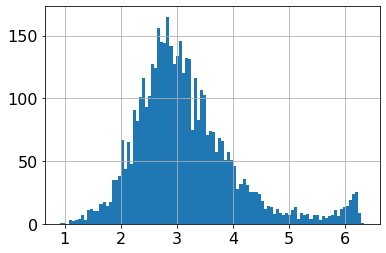

In [5]:
test[tgt].hist(bins=100)

In [ ]:
for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    group_kfold = GroupKFold(n_splits=5)

    ttprint(f'spatial CV for {model_name}')
    y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=group_kfold, groups=train[spatial_cv_column], n_jobs=90)
    ttprint(f'finish spatial cv')
    
    # calculate metrix, and visualize the results
    r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name + '-CV') # visuliazation
    
    if independent_validation == 1:
        ttprint(f'fitting mapie for {model_name}')
        mapie = MapieRegressor(model, method="minmax", cv=5, n_jobs=90) # this cv is to compute the conformal scores, and spatial cross validation
        mapie.fit(train[covs], train[tgt], groups=train[spatial_cv_column])
        ttprint(f'finish fitting mapie')
        y_pred_val, y_pis = mapie.predict(test[covs], alpha=0.1) # 90% prediction interval, 5%-95%
        
        joblib.dump(mapie, f'{folder}/SOC-EU/model/test_mapie_{model_name}.joblib')
        picp, pi_width = uncertainty_plot(test[tgt], y_pred_val, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
        # calculate metrix
        r2_val, rmse_val, ccc_val = accuracy_plot(test[tgt], y_pred, model_name+ '-independent validation') # visuliazation
    else:
        picp = np.nan
        pi_width = np.nan
        r2_val = np.nan
        rmse_val = np.nan
        ccc_val = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2_CV': r2_cv,
        'RMSE_CV': rmse_cv,
        'CCC_CV': ccc_cv,
        'R2_val': r2_val,
        'RMSE_val': rmse_val,
        'CCC_val': ccc_val,
        'PICP': picp,
        'PI width': pi_width
    })

In [2]:
# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*model*')
model_list = [str(i) for i in model_list]

results = []
normal_space = 0
uncertainty = 0

X = train
Y = test

for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    ttprint(f'start evaluating {model_name} with spatial cross validation')
    if uncertainty ==1:
        mapie = MapieRegressor(model, method="minmax", cv=5, n_jobs=90) # this cv is to compute the conformal scores, and spatial cross validation
        mapie.fit(X[covs], X[tgt], groups=X[spatial_cv_column])
#         y_pred, y_pis = mapie.predict(Y[covs], alpha=0.1) # 90% prediction interval, 5%-95%
        y_pred, y_pis = mapie.predict(X[covs], alpha=0.1)

        joblib.dump(mapie, f'{folder}/SOC-EU/model/test_mapie_{model_name}.joblib')
    else:
        y_pred = cross_val_predict(model, X[covs], X[tgt], cv=5, groups=X[spatial_cv_column], n_jobs=90)
        
    ttprint('finish spatial cross validation')
    

    if normal_space==1:
        tgt = 'oc'
        y_pred = np.expm1(y_pred)
        if uncertainty == 1:
            y_pis = np.expm1(y_pis)
        
    # calculate metrix
    r2, rmse, ccc = accuracy_plot(Y[tgt], y_pred, model_name) # visuliazation
    if uncertainty ==1:
        picp, pi_width = uncertainty_plot(Y[tgt], y_pred, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
    else:
        picp = np.nan, pi_width = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2': r2,
        'RMSE': rmse,
        'CCC': ccc,
        'PICP': picp,
        'PI width': pi_width
    })


[10:04:07] start evaluating rf with spatial cross validation


NameError: name 'cross_val_predict' is not defined

### evaluate all the models with individual validation dataset

In [ ]:
# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*mapie*')
model_list = [str(i) for i in model_list]

results = []
normal_space = 0
uncertainty = 1

X = train
Y = test

for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    ttprint(f'start evaluating {model_name} with spatial cross validation')
    if uncertainty ==1:
        y_pred, y_pis = mapie.predict(Y[covs], alpha=0.1) # 90% prediction interval, 5%-95%
    else:
        y_pred = cross_val_predict(model, X[covs], X[tgt], cv=5, groups=X[spatial_cv_column], n_jobs=90)
        
    ttprint('finish spatial cross validation')
    
    if normal_space==1:
        tgt = 'oc'
        y_pred = np.expm1(y_pred)
        if uncertainty == 1:
            y_pis = np.expm1(y_pis)
        
    # calculate metrix
    r2, rmse, ccc = accuracy_plot(Y[tgt], y_pred, model_name) # visuliazation
    if uncertainty ==1:
        picp, pi_width = uncertainty_plot(Y[tgt], y_pred, y_pis[:, 0, 0], y_pis[:, 1, 0], model_name) # visualization
    else:
        picp = np.nan, pi_width = np.nan

    # Store the results for the current feature set
    results.append({
        'title': model_name,
        'R2': r2,
        'RMSE': rmse,
        'CCC': ccc,
        'PICP': picp,
        'PI width': pi_width
    })


In [ ]:
### distribution plot

In [8]:
                
# from sklearn.model_selection import cross_val_predict
# from tool_kit import error_spatial_plot
# # get all the trained models
# model_list = find_files(f'{folder}/SOC-EU/model/','*model*.joblib')
# model_list = [str(i) for i in model_list]
# model_list = [i for i in model_list if 'log1p' in i]

# results = []

# for model_path in model_list[1::]:
#     model_name = model_path.split('_')[-1][0:-7]
#     model = joblib.load(model_path)
    
#     if 'log1p' in model_path:
#         tgt = 'oc_log1p'
#     else:
#         tgt = 'oc'
        
#     group_kfold = GroupKFold(n_splits=5)

#     ttprint(f'spatial CV for {model_name}, from {model_path}')
    
#     if sample_weights ==0:
#         y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=group_kfold, groups=train[spatial_cv_column], n_jobs=90)
#     else:
#         y_pred_cv = cross_val_predict(model, train[covs], train[tgt], cv=group_kfold, sample_weight=sample_weights, groups=train[spatial_cv_column], n_jobs=90)
#     ttprint(f'finish spatial cv')
    
#     # calculate metrix, and visualize the results
#     r2_cv, rmse_cv, ccc_cv = accuracy_plot(train[tgt], y_pred_cv, model_name + '-CV') # visuliazation
#     error_spatial_plot(train[tgt], y_pred_cv, train['lat'], train['lon'], model_name)
#     sorted_plot(train[tgt],y_pred_cv,model_name)

#     # Store the results for the current feature set
#     results.append({
#         'title': model_name,
#         'R2_CV': r2_cv,
#         'RMSE_CV': rmse_cv,
#         'CCC_CV': ccc_cv
#     })
    
# results_cv = pd.DataFrame(results)
# results_cv.to_csv(f'{folder}/SOC-EU/model/test_metrics_cv.base.model.csv', index=False)
# results_cv 